<a href="https://colab.research.google.com/github/MissTiny/Graph_Mining_Node_Edge_K-Mean_Clustering/blob/main/GA_K_means_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports.

In [1]:
import json
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
import math

Reading Signed network.

In [2]:
signed_network = nx.read_weighted_edgelist('soc-sign-Slashdot090221.txt.gz', comments='#', create_using=nx.DiGraph(), nodetype = int)

Reading node features.

In [4]:
node_features ={}
no_of_features = 100
line_no = 0
with open("embedded-soc-sign-slashdot") as nf: 
    Lines = nf.readlines() 
    for line in Lines:
        #skip first line
        if line_no > 0:
            # splitting by space
            values = line.split()
            values = values[:no_of_features+1]
            index = 0
            # reading node features
            for val in values:
                if index == 0:
                    # reading nodeIds for first time
                    if line_no == 1:
                        node_features["nodeId"] = [int(val)]
                    else:
                        node_features["nodeId"].append(int(val))
                
                elif index > 0:
                    # reading features for the first time
                    if line_no == 1:
                        node_features["feature"+str(index)] = [float(val)]
                    else:
                        node_features["feature"+str(index)].append(float(val))
                index+=1
        line_no += 1

node_features_df = pd.DataFrame(node_features)

Determining optimal number of clusters or number of active centers using elbow method.

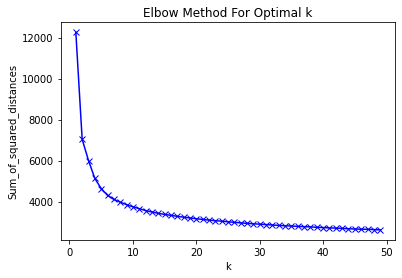

In [5]:
# To give equal importance to all features, we need to scale the continuous features. 
# We will be using scikit-learn’s MinMaxScaler as the feature matrix is a mix of binary and continuous features . 
mms = MinMaxScaler()
mms.fit(node_features_df)
node_features_df_transformed = mms.transform(node_features_df)

Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k, n_jobs=-1)
    km = km.fit(node_features_df_transformed)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

From above elbow plot, it looks like optimal value of K is 7.

In [ ]:
K = 7

Extracting node Ids.

In [ ]:
nodeIds = list(node_features_df["nodeId"])

Function to calculate profile similarities.

In [ ]:
# based on euclidean distance
def profSimilarity(nodeId, active_center, active_centers):
    nodeId_index = nodeIds.index(nodeId)
    ac_index = active_centers.index(active_center)
    # setting to 1 to avoid division by zero error
    sum = 1
    for i in range(0, no_of_features):
        sq_diff = (node_features_df["feature"+str(i+1)][nodeId_index] - node_features_df["feature"+str(i+1)][ac_index])**2
        sum += sq_diff

    # returning inverse as high value means less similarity.
    return 1/math.sqrt(sum)

Function to determine whether edge exists or not.

In [ ]:
def edgeExists(node1, node2):
    if signed_network.has_edge(node1, node2):
        return 1
    else:
        return 0

Function to calculate strength of ties.

In [ ]:
# For the computation,
# we have borrowed the idea of base node similarity,57
# where more the number of links a user shares with its
# neighbors, less becomes the strength of ties existing
def strengthOfTies(node1, node2):
    sum = 0
    for degree in list(dict(signed_network.out_degree([node1])).values()):
        sum+=degree
    for degree in list(dict(signed_network.in_degree([node2])).values()):
        sum+=degree

    sum -= 1
    
    if sum <= 0:
      return 0
    
    return 1/sum

Function to find residual area (those neighbors of given nodes that are not in the social circle).

In [ ]:
def residualArea(x,circle):
    residual = list(signed_network.neighbors(x))
    for re in residual:
        if re in circle:
            residual.remove(re)
    return residual

Function to calculate degree centrality.

In [ ]:
def degreeCentrality(x,circle):
    degree = 0 # in-degree + out-degree
    for c in circle:
        if signed_network.has_edge(x, c):
            degree+=1
        if signed_network.has_edge(c, x):
            degree+=1
    # error if len(circle) = 1
    if len(circle) ==1:
        deg_cen = degree
    else:
        deg_cen = degree/(len(circle)-1)
    return deg_cen

Funtion to discover social circle using K-means.

In [ ]:
def algorithm1(nodeIds,active_centers, add_trust_ftr = False):
    social_circles = {}
    nodeIdsWAC = list(set(nodeIds) - set(active_centers))
    for i in range (0, K):
        active_center = active_centers[i]
        social_circles[str(active_center)] = []
    for nodeId in nodeIdsWAC:
        maxS = 0
        # active_center which will be most similar to given node
        selectedAC = -1
        for i in range (0, K):
            active_center = active_centers[i]
            p1 = 0 # edge exists from active center to node
            p2 = 0 # edge exists from node to active center
            p3 = 0
            p4_1 = 0 # strength of ties between active center and node  
            p4_2 = 0 # strength of ties between node and active center 
            p5_1 = 0 # trust between active center and node
            p5_2 = 0 # trust between node and active center

            p1 = edgeExists(active_center, nodeId)
            p2 = edgeExists(nodeId, active_center)

            if p1 or p2:
              p3 = profSimilarity(nodeId, active_center, active_centers)

            if p1:
              p4_1 = strengthOfTies(active_center, nodeId)
              if add_trust_ftr:
                p5_1 = signed_network.get_edge_data(active_center, nodeId, default={'weight':0})['weight']
            
            if p2:
                p4_2 = strengthOfTies(nodeId, active_center)
                if add_trust_ftr:
                  p5_2 = signed_network.get_edge_data(nodeId, active_center, default={'weight':0})['weight']            

            if maxS < p1 + p2 + p3 + p4_1 + p4_2 + p5_1 + p5_2:
                maxS = p1 + p2 + p3 + p4_1 + p4_2 + p5_1 + p5_2
                selectedAC = active_center
      
        if selectedAC != -1:
            social_circles[str(selectedAC)].append(nodeId)

    return social_circles

Initializing variables for Genetic Algorithm.

In [ ]:
#center selection
##population size = 20
N = 20
population = []
random.seed(0)

Generating random population (sets of active centers) randomly.

In [ ]:
for i in range(0,N):
    selected = random.sample(nodeIds,K)
    if selected not in population:
        population.append(selected)

Algorithm2_part1 takes one group of centers and return the fitness of it.

In [ ]:
def algorithm2_part1(pop_n, add_trust_ftr = False):
    Xi = pop_n
    Cij = algorithm1(nodeIds,Xi, add_trust_ftr)
    
    obj=0
    for k in range(0,K):
        #initialize k=1 and obj=0
        xi = Xi[k]
        
        residual =  residualArea(xi,Cij[str(xi)])
        #deg_cen
        deg_cen_C = degreeCentrality(xi,Cij[str(xi)])
        deg_cen_R = degreeCentrality(xi,residual)
        
        #prof_sim
        prof_sim_C = 0
        for c in Cij[str(xi)]:
            prof_sim_C+=profSimilarity(c, xi,Xi)
        prof_sim_C = prof_sim_C/len(Cij)
        
        prof_sim_R = 0
        for r in residual:
            prof_sim_R+=profSimilarity(r, xi,Xi)
        if len(residual) != 0:
            prof_sim_R = prof_sim_R/len(residual)
        
        #str_C
        str_C = 0
        for c in Cij[str(xi)]:
            str_C+= strengthOfTies(c, xi)
            str_C+= strengthOfTies(xi, c)
        str_C = str_C/len(Cij)
        
        str_R = 0
        for r in residual:
            str_R+= strengthOfTies(r, xi)
            str_R+= strengthOfTies(xi, r)
        if len(residual) != 0:
             str_R = str_R/len(residual)

        #str_C
        trust_C = 0
        trust_R = 0
        if add_trust_ftr:
          for c in Cij[str(xi)]:
              trust_C += signed_network.get_edge_data(c, xi, default={'weight':0})['weight']
              trust_C += signed_network.get_edge_data(xi, c, default={'weight':0})['weight']
          trust_C = trust_C/len(Cij)
          
        if add_trust_ftr:  
          for r in residual:
              trust_R += signed_network.get_edge_data(r, xi, default={'weight':0})['weight']
              trust_R += signed_network.get_edge_data(xi, r, default={'weight':0})['weight']
          if len(residual) != 0:
              trust_R = trust_R/len(residual)
       
        
        obj+=deg_cen_C - deg_cen_R + prof_sim_C - prof_sim_R + str_C - str_R + trust_C - trust_R
    
    
    return obj/K

Calculating fitness value of generated population.

In [ ]:
#initialize n=1 and fitness = 0
fitness=[]
for n in range(0,N):
    #pick up the ith row from X_ij and Cij
    fit_val = algorithm2_part1(population[n])
    print("Population # " + str(n)+ " fitness value: " + str(fit_val))
    print(population[n])
    fitness.append(fit_val)

Population # 0 fitness value: 0.16694300896898748
[64587, 59883, 6270, 24110, 63988, 34268, 19711]
Population # 1 fitness value: 0.7812684271077559
[48573, 44222, 21376, 79233, 32003, 44902, 61068]
Population # 2 fitness value: 0.4320722431253147
[52530, 77476, 16376, 37260, 11872, 71229, 32532]
Population # 3 fitness value: 0.9762287814384587
[36343, 64662, 38078, 49657, 46958, 35759, 69911]
Population # 4 fitness value: 1.5665334707848566
[75474, 41699, 52844, 40741, 18143, 21830, 29678]
Population # 5 fitness value: 1.3471202426776863
[58826, 75731, 52830, 24139, 31145, 77312, 10825]
Population # 6 fitness value: 1.3792106622001632
[3261, 54331, 65558, 26313, 51381, 52700, 21231]
Population # 7 fitness value: 0.8169042029541248
[23858, 38555, 3600, 16210, 58956, 27831, 19626]
Population # 8 fitness value: 0.8484771903659107
[22231, 68668, 4455, 30374, 2604, 50934, 56730]
Population # 9 fitness value: 1.2445626251178
[54997, 283, 26482, 59329, 16491, 79832, 36660]
Population # 10 fit

Functions to check the format of generated Q offspring (new set of active centers generated after crossover and mutation).

In [ ]:
def check(matrix):
    for i in matrix:
        if len(i)!=8:
            print("error in row: ",i)

Applying Crossover and mutation operation to determine best set of active centers.

In [ ]:
# hardcoding population values generated from previous cells in last run
# fitness = []
# population = []
# fitness.append(0.16694300896898748)
# population.append([64587, 59883, 6270, 24110, 63988, 34268, 19711])
# fitness.append(0.7812684271077559)
# population.append([48573, 44222, 21376, 79233, 32003, 44902, 61068])
# fitness.append(0.4320722431253147)
# population.append([52530, 77476, 16376, 37260, 11872, 71229, 32532])
# fitness.append(0.9762287814384587)
# population.append([36343, 64662, 38078, 49657, 46958, 35759, 69911])
# fitness.append(1.5665334707848566)
# population.append([75474, 41699, 52844, 40741, 18143, 21830, 29678])
# fitness.append(1.3471202426776863)
# population.append([58826, 75731, 52830, 24139, 31145, 77312, 10825])
# fitness.append(1.3792106622001632)
# population.append([3261, 54331, 65558, 26313, 51381, 52700, 21231])
# fitness.append(0.8169042029541248)
# population.append([23858, 38555, 3600, 16210, 58956, 27831, 19626])
# fitness.append(0.8484771903659107)
# population.append([22231, 68668, 4455, 30374, 2604, 50934, 56730])
# fitness.append(1.2445626251178)
# population.append([54997, 283, 26482, 59329, 16491, 79832, 36660])
# fitness.append(0.5788026877481894)
# population.append([80178, 22687, 55944, 42447, 14540, 53054, 64168])
# fitness.append(1.36370968196743)
# population.append([60363, 63168, 76186, 41677, 62668, 76935, 16687])
# fitness.append(0.8312547041780688)
# population.append([56044, 6661, 3778, 28170, 6486, 20810, 69801])
# fitness.append(0.57485892422818)
# population.append([74457, 10533, 6545, 26993, 449, 3138, 445])
# fitness.append(1.1209826378069088)
# population.append([69384, 14394, 74774, 33456, 30070, 40242, 77539])
# fitness.append(0.6159093503314556)
# population.append([13709, 48161, 74950, 65113, 55583, 65011, 70614])
# fitness.append(1.1757070037264281)
# population.append([44499, 16623, 35101, 6148, 77303, 13565, 32111])
# fitness.append(1.8040354694734257)
# population.append([42992, 80803, 2904, 12224, 26148, 23142, 54434])
# fitness.append(1.154459797636625)
# population.append([76153, 23314, 13756, 167, 16535, 80062, 30663])
# fitness.append(0.3834292775871229)
# population.append([27966, 67681, 56635, 41123, 24357, 2156, 65159])

#####

# Part two
##Augmented matrix Q containing fitness value for each set of active center
Q=[]
for i in range(0,len(fitness)):
    Qi = population[i].copy()
    Qi.append(fitness[i])
    Q.append(Qi)

In [ ]:
# re-sort in descending order
# since there are K elements in each set then we have fitness value at K index
fit_val_index = K
Q_desc= sorted(Q,key=lambda x:x[fit_val_index],reverse=True)
## for resuming GA execution (without trust feature)
# Q_desc.insert(0, [36343, 3815, 2904, 4244, 1710, 35556, 2057, 4.972640785178261])
# Q_desc.insert(1, [36343, 3815, 2904, 25472, 1710, 23421, 50179, 3.6131643247035625])
# Q_desc.insert(2, [36343, 3815, 2904, 4244, 1710, 20355, 12154, 3.5632871193838156])
# Q_desc.insert(3, [36343, 3815, 2904, 25472, 1710, 20355, 12154, 3.535242427980814])
# Q_desc.insert(4, [36343, 3815, 2904, 25472, 26148, 4869, 57450, 3.1613215901733347])
# Q_desc.insert(5, [36343, 63875, 2904, 25472, 26148, 4869, 52151, 2.6771110398384708])
# Q_desc.insert(6, [36343, 64662, 2904, 25472, 26148, 4869, 57450, 2.6753847308687546])
# Q_desc.insert(7, [36343, 64662, 2904, 25472, 26148, 4869, 43904, 2.521897593451154])
# Q_desc.insert(8, [36343, 64662, 2904, 25472, 26148, 23142, 43904, 2.3900752125297147])
# Q_desc.insert(9, [9756, 80803, 2904, 12224, 26148, 23142, 77539, 1.945921176283259])
# Q_desc = Q_desc[:20]
# Q_desc= sorted(Q_desc,key=lambda x:x[fit_val_index],reverse=True)
##


Locally optimum version of GA (convergence quickly but doesn't gurantee best set of active centers w.r.t global context).

In [ ]:
def parallel_insider_algorithm2_part2(i,Q_desc,K,nodeIds,signed_network,node_features_df, add_trust_ftr = False):
    import random
    #print(i)
    # Q_high = list(filter(lambda x:x[K]>1,Q_desc))
    # if len(Q_high) >10:
    #     Q_high = Q_high[:10]

    Q_high = Q_desc[:10]
    #print(Q_high)
    Q1 = random.choice(Q_high)

    #print(Q1,Q2)
    x1 = Q1[:-1]
    x1_fit = Q1[-1]
    Q2 = random.choice(Q_high)
    x2 = Q2[:-1]
    x2_fit = Q2[-1]
    while x2 == x1:
        Q2 = random.choice(Q_high)
        x2 = Q2[:-1]
        x2_fit = Q2[-1]
    #random.seed(0)
    randc_pos = random.randint(1,K)

    x1_new = x1[:randc_pos]+x2[randc_pos:]
    x2_new = x2[:randc_pos]+x1[randc_pos:]

    x1_new_fit = algorithm2_part1(x1_new, add_trust_ftr)
    x2_new_fit = algorithm2_part1(x2_new, add_trust_ftr)

    max_fit = max(x1_fit,x2_fit,x1_new_fit,x2_new_fit)
    value="null"
    if(x1_fit == max_fit):
        x = x1
        value="x1"
        #print("x1 is the best")
    elif (x2_fit == max_fit):
        x = x2
        value="x2"
        #print("x2 is the best")
    elif (x1_new_fit == max_fit):
        x = x1_new
        value="x1_new"
        #print("x1 new is the best")
    else:
        x = x2_new
        value="x2_new"
        #print("x2 new is the best")

###################original thought###################################        
#         x1 = Q_desc[i][:-1]
#         x2 = Q_desc[i+1][:-1]

#         #cross over
#         #generate a random int randc_pos
#         random.seed(0)
#         randc_pos = randint(1,K)

#         x1_new = x1[:randc_pos]+x2[randc_pos:]
#         x2_new = x2[:randc_pos]+x1[randc_pos:]
#########################################################
    #mutation
    #generate a random position randm_pos [1,k] and rand_id [1,n]
    randm_pos = random.randint(1,K)
    rand_id = random.choice(nodeIds)

    #x = x1_new
    #x = Q_desc[i]
    #repair chomorosome if values of two alleles of a chromosome occurs
    if rand_id in (x[:randm_pos-1]+x[randm_pos:]):
        x_new =x
    else:
        x_new = x[:randm_pos-1]+[rand_id]+x[randm_pos:]
        
        #if len(x_new) !=7:
        #    
        #    print("In x_new i =",i,"random pos ",randm_pos," randc pos ",
        #          randc_pos,"x has more ", x,"x takes the value",value,
        #          "x2: ", x2, "Q2:", Q2,
        #         "x1:", x1)

    x_new_fit = algorithm2_part1(x_new, add_trust_ftr)
    #print("This is x_new_fit:", str(x_new_fit),"This is Q_desc[i][-1]",str(Q_desc[i][-1]))
    #print(i,": end")
    if (x_new_fit > Q_desc[i][-1]):
        #print("Fit better: i is ",i," ", x_new + [x_new_fit])
        return x_new + [x_new_fit]
    else:
        #print("Orgin better: i is ",i," ", Q_desc[i])
        return Q_desc[i]

Globally optimum version of GA (gurantees best set of active centers but convergences slowly).

In [ ]:
from multiprocessing import Pool

def run_global_optimum_ga(add_trust_ftr = False):
    
    print("Running global optimum Genetic Algorithm for best set of active centers.")

    iteration = 0
    Q_desc_temp = Q_desc.copy()
    Q_desc_new_global=[]
    pre_fit = 0
    while iteration <10:
        if (Q_desc_new_global != []):
            Q_desc_temp = Q_desc_new_global
            pre_fit = Q_desc_temp[0][-1]
            Q_desc_new_global = []
        pool = Pool()
        result_async = [pool.apply_async(parallel_insider_algorithm2_part2, 
                                         args = (i,Q_desc_temp,K,nodeIds,signed_network,node_features_df, add_trust_ftr)) for i in range(N)] 
        Q_desc_new_global = [r.get() for r in result_async] 
        Q_desc_new_global=sorted(Q_desc_new_global,key=lambda x:x[-1],reverse=True)
        check(Q_desc_new_global)
        #print(Q_desc_new_global)
        if Q_desc_new_global[0][-1] == pre_fit:
            iteration +=1
        else:
            iteration=1
        print("Best fitness value is ",str(Q_desc_new_global[0][-1]),", and iteration currently is ", str(iteration))
        print(Q_desc_new_global[0][:K])
    
    return Q_desc_new_global[0][:K]

Getting globally optimum social circles without considering link/trust feature.

In [ ]:
ac_wo_trust = run_global_optimum_ga()
print("Best Set of Active Centers without trust feature:")
print(ac_wo_trust)
print("Generating Social Circles.")
sc_wo_trust = algorithm1(nodeIds, ac_wo_trust)
print("Social Circles without trust:")
print(sc_wo_trust)

Running global optimum Genetic Algorithm for best set of active centers.
Best fitness value is  5.500167823023391 , and iteration currently is  1
[3253, 3815, 2904, 4244, 1710, 35556, 2057]
Best fitness value is  5.500167823023391 , and iteration currently is  2
[3253, 3815, 2904, 4244, 1710, 35556, 2057]
Best fitness value is  5.500167823023391 , and iteration currently is  3
[3253, 3815, 2904, 4244, 1710, 35556, 2057]
Best fitness value is  5.500167823023391 , and iteration currently is  4
[3253, 3815, 2904, 4244, 1710, 35556, 2057]
Best fitness value is  5.586402121653843 , and iteration currently is  1
[3253, 3815, 2904, 759, 1710, 20234, 2057]
Best fitness value is  5.586402121653843 , and iteration currently is  2
[3253, 3815, 2904, 759, 1710, 20234, 2057]
Best fitness value is  5.586402121653843 , and iteration currently is  3
[3253, 3815, 2904, 759, 1710, 20234, 2057]
Best fitness value is  5.586402121653843 , and iteration currently is  4
[3253, 3815, 2904, 759, 1710, 20234, 2

Function to calculate net values of the properties (degree centrality, strenght of ties, profile similarity, objective function value).

In [ ]:
# values generated after the convergence of global genetic algorithm
ac_wo_trust = [3253, 3815, 2904, 53361, 1710, 1877, 2057]
sc_wo_trust = {'3253': [149, 366, 397, 653, 656, 667, 1404, 1566, 1617, 1694, 1737, 1833, 1850, 2225, 2438, 2447, 2888, 3054, 3066, 3196, 3245, 3451, 3480, 3531, 3545, 3555, 3566, 3646, 3709, 3888, 4025, 4303, 4343, 4360, 4393, 4411, 4444, 4445, 4546, 4618, 4621, 4664, 4729, 4733, 4779, 5093, 5185, 5299, 5572, 5758, 5856, 5971, 6107, 6157, 6288, 6377, 6418, 7373, 7615, 7618, 7626, 8051, 8203, 8269, 8388, 8783, 8897, 8914, 8954, 8959, 9193, 9285, 9537, 9833, 9891, 10103, 10455, 10815, 11059, 11619, 11742, 11809, 11816, 11897, 12831, 12985, 13096, 13187, 13825, 14156, 15037, 15506, 16415, 16567, 16750, 16772, 16853, 16990, 17480, 17686, 18497, 18597, 19154, 19472, 19686, 20275, 21396, 21522, 21766, 22017, 22045, 22593, 22618, 22921, 23207, 23267, 23722, 23819, 24037, 24278, 24781, 25017, 25212, 25527, 25717, 25847, 27102, 28134, 28731, 29123, 29144, 29478, 29943, 30000, 30317, 30539, 30698, 30916, 31697, 32229, 32295, 35854, 35889, 35931, 35936, 36621, 38270, 38443, 38675, 38835, 38888, 39299, 39397, 39579, 39678, 40359, 41337, 42330, 42773, 44706, 44859, 47266, 47453, 53970, 54119, 56462, 56598, 57629, 59185, 63533, 63574, 63844, 65148, 65214, 67903, 67937, 70502, 71365, 72080, 72383, 72683, 72726, 74868, 74869, 74870, 74871, 74874, 76273], '3815': [458, 531, 746, 869, 1239, 1266, 1297, 1495, 1703, 1758, 2131, 2140, 2254, 2618, 2889, 3140, 3149, 3248, 3426, 3527, 3534, 4084, 4337, 4342, 4791, 4844, 4913, 4963, 5140, 5322, 5447, 6209, 6385, 6574, 7039, 7324, 7580, 8158, 8190, 8694, 8705, 8921, 9591, 10028, 10588, 10763, 11391, 11731, 11808, 12034, 12257, 12358, 13212, 13396, 13420, 14194, 14424, 14614, 14694, 15116, 15675, 15849, 15899, 15913, 16368, 16647, 16663, 17179, 17202, 17822, 18256, 18546, 18888, 19612, 20785, 21520, 21877, 22101, 22156, 23385, 23839, 24056, 25853, 26328, 26790, 26908, 29001, 29059, 29163, 29213, 30163, 31253, 31620, 31883, 32024, 33733, 34729, 37379, 40668, 41123, 41138, 43362, 49161, 51125, 52459, 57548, 58088, 59172, 60068, 61070, 61759, 63880, 65839, 65909, 66594, 68092, 68583, 68709, 69714, 75281, 75282, 75283, 75284, 75285, 75286, 75287], '2904': [68, 324, 1323, 1389, 1630, 2170, 2908, 2951, 3641, 3751, 4057, 4738, 4772, 4894, 5102, 5438, 5506, 7410, 7416, 8610, 9037, 9235, 9918, 10747, 11611, 11637, 11779, 11963, 12441, 14931, 15863, 15889, 16275, 16592, 16759, 18489, 18533, 18878, 19148, 19290, 19384, 20283, 20972, 21927, 22119, 22368, 22668, 23109, 24150, 24363, 24413, 24839, 25126, 25624, 26023, 26107, 26396, 26857, 27603, 28314, 28583, 29463, 30201, 30530, 30737, 30791, 31494, 31776, 31858, 32113, 32423, 32508, 33009, 33199, 33529, 34429, 35203, 35406, 36373, 37392, 37920, 39804, 40145, 41131, 41536, 50332, 50674, 54181, 56235, 57316, 57555, 58511, 63285, 64333, 64723, 64824, 65150, 65292, 65546, 67012, 67046, 68562, 68647, 68900, 69260, 74214, 74642, 74643, 74644], '53361': [7732, 53364], '1710': [53, 79, 180, 627, 744, 799, 807, 980, 1001, 1450, 1493, 1635, 1810, 1829, 2141, 2189, 2230, 2446, 2556, 2557, 2714, 2749, 2755, 2782, 2906, 2960, 3059, 3080, 3137, 3738, 3761, 4098, 4341, 5236, 5244, 5300, 5561, 5568, 5898, 5928, 6435, 6469, 6485, 7188, 7441, 7572, 7586, 7641, 7656, 7663, 7802, 7874, 7941, 7957, 7988, 8061, 8068, 8266, 8329, 8585, 8686, 9057, 9304, 9422, 10173, 10524, 10619, 11365, 11594, 11824, 11896, 12061, 13284, 13355, 13416, 13438, 13812, 13961, 14494, 14696, 14962, 15320, 15408, 15586, 15847, 16110, 16111, 16490, 16643, 17208, 17311, 17351, 17527, 18203, 18524, 19778, 21213, 21712, 22105, 22107, 22681, 22952, 23165, 24055, 24657, 25883, 25998, 26024, 26067, 26487, 26676, 27008, 27171, 27193, 27577, 27789, 28378, 28814, 31322, 31404, 31698, 36230, 36382, 36503, 36671, 36693, 36814, 37073, 39725, 41153, 44664, 45826, 48343, 49807, 49909, 51963, 55499, 60670, 63644, 63769, 64619, 66098, 71519, 71854, 73153, 73154, 73156, 73157, 76284, 76648], '1877': [3, 9, 17, 21, 25, 29, 47, 50, 52, 55, 59, 66, 67, 69, 70, 71, 73, 76, 83, 87, 88, 89, 92, 94, 112, 144, 168, 176, 182, 185, 226, 258, 273, 290, 330, 425, 455, 501, 616, 624, 640, 657, 662, 668, 673, 678, 684, 811, 813, 824, 830, 884, 895, 899, 905, 908, 911, 912, 921, 923, 926, 928, 929, 937, 938, 940, 949, 957, 958, 968, 973, 974, 976, 989, 998, 1000, 1004, 1005, 1011, 1013, 1018, 1028, 1035, 1038, 1051, 1055, 1063, 1069, 1070, 1075, 1078, 1088, 1111, 1116, 1120, 1123, 1130, 1143, 1146, 1148, 1150, 1153, 1161, 1174, 1176, 1177, 1183, 1203, 1213, 1226, 1234, 1310, 1324, 1327, 1350, 1353, 1359, 1412, 1434, 1463, 1484, 1494, 1520, 1536, 1559, 1574, 1700, 1723, 1793, 1812, 1838, 1849, 1858, 1869, 1872, 1894, 1918, 1921, 1923, 1939, 1942, 2033, 2061, 2102, 2108, 2115, 2117, 2146, 2172, 2181, 2200, 2207, 2239, 2277, 2284, 2415, 2468, 2494, 2498, 2503, 2505, 2506, 2511, 2513, 2522, 2528, 2533, 2539, 2540, 2541, 2542, 2546, 2547, 2549, 2562, 2570, 2573, 2576, 2577, 2585, 2592, 2593, 2619, 2631, 2633, 2670, 2695, 2796, 2824, 2866, 2896, 2900, 2919, 2930, 2938, 2939, 2970, 2973, 2994, 2999, 3205, 3455, 3491, 3617, 3704, 3753, 3873, 4014, 4263, 4375, 4499, 4514, 4562, 4581, 4602, 4693, 4696, 4697, 4719, 4857, 4941, 4956, 4976, 4994, 4999, 5049, 5052, 5060, 5088, 5094, 5096, 5141, 5217, 5250, 5253, 5276, 5281, 5316, 5326, 5651, 5779, 5781, 6036, 6133, 6147, 6201, 6293, 6297, 6299, 6307, 6771, 6790, 6796, 6803, 6813, 6816, 6852, 6853, 6908, 6970, 6990, 7068, 7088, 7100, 7515, 7517, 7531, 7634, 7638, 7673, 7721, 7848, 7873, 7888, 7899, 8052, 8106, 8110, 8182, 8217, 8247, 8330, 8402, 8403, 8405, 8482, 8535, 8544, 8735, 8781, 8791, 8885, 8906, 9132, 9206, 9250, 9354, 9389, 9412, 9456, 9826, 9868, 9965, 9966, 10473, 10753, 10777, 10942, 11020, 11033, 11044, 11196, 11217, 11242, 11554, 11657, 11741, 12290, 12291, 12292, 12293, 12294, 12295, 12296, 12297, 12298, 12299, 12300, 12301, 12302, 12303, 12304, 12305, 12306, 12307, 12308, 12309, 12310, 12311, 12312, 12313, 12314, 12315, 12316, 12317, 12318, 12319, 12320, 12321, 12322, 12323, 12324, 12325, 12326, 12327, 12328, 12329, 12330, 12331, 12332, 12333, 12334, 12335, 12336, 12337, 12338, 12339, 12340, 12341, 12543, 13217, 13245, 13344, 14387, 14900, 15273, 16737, 17384, 17808, 18577, 18721, 20298, 20719, 22414, 23037, 24648, 25764, 25768, 28984, 29975, 37202, 37470, 39510, 39557, 40078, 43443, 45418, 46107, 50835, 58325, 58334], '2057': [38, 169, 277, 331, 347, 362, 369, 576, 588, 672, 741, 745, 780, 893, 909, 979, 1090, 1208, 1240, 1340, 1381, 1534, 1537, 1761, 1815, 1876, 1952, 2110, 2111, 2265, 2269, 2281, 2497, 2537, 2572, 2580, 2761, 2791, 2829, 2858, 2872, 3086, 3160, 3161, 3162, 3177, 3185, 3269, 3274, 3576, 3585, 3588, 3627, 3703, 3712, 3813, 3875, 3942, 3943, 4252, 4273, 4299, 4300, 4401, 4448, 4487, 4616, 4639, 4852, 4921, 4951, 4987, 5010, 5150, 5225, 5267, 5279, 5308, 5315, 5464, 5499, 5500, 5565, 5573, 5633, 5636, 5654, 5906, 5917, 5927, 5958, 6051, 6141, 6311, 6317, 6333, 6547, 6659, 6664, 7363, 7571, 7604, 7754, 7825, 7831, 7842, 7850, 7951, 8141, 8171, 8227, 8496, 8518, 8759, 8895, 8896, 8938, 8996, 9172, 9279, 9488, 9512, 9567, 9570, 9738, 9841, 9854, 9996, 10041, 10256, 10332, 10339, 10457, 10467, 11163, 11320, 11628, 11728, 12280, 12430, 12771, 12793, 13036, 13075, 13097, 13371, 13632, 14243, 14428, 14463, 14613, 14685, 14742, 14835, 14858, 15011, 15212, 15364, 15370, 15753, 15765, 15790, 15858, 15932, 15934, 16221, 16405, 16430, 16633, 16719, 16788, 17038, 17141, 17462, 17510, 17594, 17715, 17769, 17792, 17841, 17957, 18370, 18731, 19111, 19639, 19651, 19687, 19883, 19987, 19996, 20273, 20600, 20654, 20816, 20915, 21251, 21299, 21730, 21947, 22069, 22306, 22318, 22434, 22611, 23028, 23217, 23276, 24017, 24034, 24167, 24168, 24233, 24294, 24699, 25366, 25584, 25734, 26114, 26335, 26651, 26937, 27021, 27474, 27601, 27814, 28085, 28269, 28543, 28725, 28785, 29076, 29124, 29347, 30150, 30601, 30732, 30801, 31374, 31390, 31491, 31792, 32454, 33177, 33230, 33718, 33784, 33984, 34001, 34059, 34264, 34778, 35062, 35096, 36520, 36682, 37153, 37197, 37723, 38696, 39151, 39916, 40769, 40839, 41559, 43054, 43361, 44474, 45086, 45151, 47944, 48094, 49756, 50643, 50819, 51835, 53071, 54150, 54534, 54535, 54683, 55077, 55240, 55271, 55547, 55879, 56931, 57121, 58072, 58142, 58695, 62512, 64098, 65637, 65730, 68990, 69252, 69473, 70437, 70600, 70732, 71625, 71941, 71990, 73650, 73651, 73652, 73654, 73655, 73656, 73659]}
#########
def get_net_values(social_circle, active_centers):
  net_deg_cen_C = 0
  net_deg_cen_R = 0
  net_str_C = 0
  net_str_R = 0
  net_prof_sim_C = 0
  net_prof_sim_R = 0
  net_obj_val = 0

  for active_center in social_circle:
    circle = social_circle[active_center]
    
    residual =  residualArea(int(active_center), circle)     
    
    deg_cen_C = degreeCentrality(int(active_center),circle)
    net_deg_cen_C += deg_cen_C
    deg_cen_R = degreeCentrality(int(active_center),residual)
    net_deg_cen_R += deg_cen_R 
    
    prof_sim_C = 0
    for c in circle:
      prof_sim_C +=profSimilarity(c, int(active_center), active_centers)
    prof_sim_C = prof_sim_C/len(circle)
    net_prof_sim_C += prof_sim_C

    prof_sim_R = 0
    for r in residual:
      prof_sim_R += profSimilarity(r, int(active_center), active_centers)
    if len(residual) != 0:
      prof_sim_R = prof_sim_R/len(residual)
    net_prof_sim_R += prof_sim_R
              
    str_C = 0
    for c in circle:
      str_C += strengthOfTies(c, int(active_center))
      str_C += strengthOfTies(int(active_center), c)
    str_C = str_C/len(circle)
    net_str_C += str_C

    str_R = 0
    for r in residual:
      str_R+= strengthOfTies(r, int(active_center))
      str_R+= strengthOfTies(int(active_center), r)
    if len(residual) != 0:
      str_R = str_R/len(residual)
    net_str_R += str_R
    net_obj_val += deg_cen_C - deg_cen_R + prof_sim_C - prof_sim_R + str_C - str_R
  
  net_deg_cen_C /= K
  net_deg_cen_R /= K
  net_str_C /= K
  net_str_R /= K
  net_prof_sim_C /= K
  net_prof_sim_R /= K
  net_obj_val /= K

  return net_deg_cen_C, net_deg_cen_R, net_str_C, net_str_R, net_prof_sim_C, net_prof_sim_R, net_obj_val

Getting net values for social circles without trust feature.

In [ ]:
net_deg_cen_C, net_deg_cen_R, net_str_C, net_str_R, net_prof_sim_C, net_prof_sim_R, net_obj_val = get_net_values(sc_wo_trust, ac_wo_trust)
print("Net Degree Centrality for circle without trust feature: " + str(net_deg_cen_C))
print("Net Degree Centrality for residual without trust feature: " + str(net_deg_cen_R))
print("Net Strength of ties for circle without trust feature: " + str(net_str_C))
print("Net Strength of ties for residual without trust feature: " + str(net_str_R))
print("Net Pofile similarity for circle without trust feature: " + str(net_prof_sim_C))
print("Net Pofile similarity for residual without trust feature: " + str(net_prof_sim_R))
print("Net Objective value without trust feature: " + str(net_obj_val))

Net Degree Centrality for circle without trust feature: 1.3543431573965286
Net Degree Centrality for residual without trust feature: 0.21858864027538724
Net Strength of ties for circle without trust feature: 0.19952012298404234
Net Strength of ties for residual without trust feature: 0.0007871506672415278
Net Pofile similarity for circle without trust feature: 0.05714673207084614
Net Pofile similarity for residual without trust feature: 0.008654539747905695
Net Objective value without trust feature: 1.3829796817608828


Resetting population values generated reandomly in previous successfull runs (usefule in case if program crashes in the middle).

In [ ]:
# hardcoding population values generated from previous cells in last run
# N=20
# fitness = []
# population = []
# fitness.append(0.16694300896898748)
# population.append([64587, 59883, 6270, 24110, 63988, 34268, 19711])
# fitness.append(0.7812684271077559)
# population.append([48573, 44222, 21376, 79233, 32003, 44902, 61068])
# fitness.append(0.4320722431253147)
# population.append([52530, 77476, 16376, 37260, 11872, 71229, 32532])
# fitness.append(0.9762287814384587)
# population.append([36343, 64662, 38078, 49657, 46958, 35759, 69911])
# fitness.append(1.5665334707848566)
# population.append([75474, 41699, 52844, 40741, 18143, 21830, 29678])
# fitness.append(1.3471202426776863)
# population.append([58826, 75731, 52830, 24139, 31145, 77312, 10825])
# fitness.append(1.3792106622001632)
# population.append([3261, 54331, 65558, 26313, 51381, 52700, 21231])
# fitness.append(0.8169042029541248)
# population.append([23858, 38555, 3600, 16210, 58956, 27831, 19626])
# fitness.append(0.8484771903659107)
# population.append([22231, 68668, 4455, 30374, 2604, 50934, 56730])
# fitness.append(1.2445626251178)
# population.append([54997, 283, 26482, 59329, 16491, 79832, 36660])
# fitness.append(0.5788026877481894)
# population.append([80178, 22687, 55944, 42447, 14540, 53054, 64168])
# fitness.append(1.36370968196743)
# population.append([60363, 63168, 76186, 41677, 62668, 76935, 16687])
# fitness.append(0.8312547041780688)
# population.append([56044, 6661, 3778, 28170, 6486, 20810, 69801])
# fitness.append(0.57485892422818)
# population.append([74457, 10533, 6545, 26993, 449, 3138, 445])
# fitness.append(1.1209826378069088)
# population.append([69384, 14394, 74774, 33456, 30070, 40242, 77539])
# fitness.append(0.6159093503314556)
# population.append([13709, 48161, 74950, 65113, 55583, 65011, 70614])
# fitness.append(1.1757070037264281)
# population.append([44499, 16623, 35101, 6148, 77303, 13565, 32111])
# fitness.append(1.8040354694734257)
# population.append([42992, 80803, 2904, 12224, 26148, 23142, 54434])
# fitness.append(1.154459797636625)
# population.append([76153, 23314, 13756, 167, 16535, 80062, 30663])
# fitness.append(0.3834292775871229)
# population.append([27966, 67681, 56635, 41123, 24357, 2156, 65159])

#####

# Part two
##Augmented matrix Q containing fitness value for each set of active center
Q=[]
for i in range(0,len(fitness)):
    Qi = population[i].copy()
    Qi.append(fitness[i])
    Q.append(Qi)

fit_val_index = K
Q_desc= sorted(Q,key=lambda x:x[fit_val_index],reverse=True)

For resuming GA execution (with trust feature).

In [ ]:
## for resuming GA execution (with trust feature)
# Q_desc.insert(0, [4206, 1144, 2904, 2161, 6842, 4329, 8265, 18.539066609081377])
# Q_desc.insert(1, [4265, 1144, 2904, 2161, 55735, 4329, 8265, 14.66418107455886])
# Q_desc.insert(2, [34154, 1144, 2904, 2161, 45711, 4329, 8265, 14.302143920412442])
# Q_desc.insert(3, [52508, 1144, 2904, 2161, 55735, 4329, 8265, 14.136262685963013])
# Q_desc.insert(4, [75474, 1144, 2904, 2161, 55735, 4329, 8265, 14.092779268091295])
# Q_desc.insert(5, [75474, 1144, 2904, 2161, 2396, 4329, 10825, 12.99149773188772])
# Q_desc.insert(6, [75474, 77585, 2904, 2161, 3451, 4329, 10825, 10.260048729057129])
# Q_desc.insert(7, [75474, 77585, 2904, 2161, 2396, 4329, 10825, 10.074299530044886])
# Q_desc.insert(8, [75474, 77585, 2904, 12224, 2396, 4329, 10825, 8.10592290153298])
# Q_desc.insert(9, [75474, 77585, 2904, 12224, 26148, 4329, 54434, 6.95098852732381])
# Q_desc.insert(10, [42992, 13232, 2904, 12224, 26148, 79832, 36660, 4.535737962743809])
# Q_desc = Q_desc[:20]
# Q_desc= sorted(Q_desc,key=lambda x:x[fit_val_index],reverse=True)

Getting globally optimum social circles by considering link/trust feature.

In [ ]:
ac_w_trust = run_global_optimum_ga(add_trust_ftr=True)
print("Best Set of Active Centers with trust feature:")
print(ac_w_trust)
print("Generating Social Circles.")
sc_w_trust = algorithm1(nodeIds, ac_w_trust)
print("Social Circles with trust:")
print(sc_w_trust)

Running global optimum Genetic Algorithm for best set of active centers.
Best fitness value is  18.539066609081377 , and iteration currently is  1
[4206, 1144, 2904, 2161, 6842, 4329, 8265]
Best fitness value is  22.91758881329108 , and iteration currently is  1
[4206, 1144, 629, 2161, 45711, 4329, 8265]
Best fitness value is  22.91758881329108 , and iteration currently is  2
[4206, 1144, 629, 2161, 45711, 4329, 8265]
Best fitness value is  22.91758881329108 , and iteration currently is  3
[4206, 1144, 629, 2161, 45711, 4329, 8265]
Best fitness value is  22.91758881329108 , and iteration currently is  4
[4206, 1144, 629, 2161, 45711, 4329, 8265]
Best fitness value is  22.99860953429511 , and iteration currently is  1
[4206, 1144, 629, 3749, 45711, 4329, 8265]
Best fitness value is  22.99860953429511 , and iteration currently is  2
[4206, 1144, 629, 3749, 45711, 4329, 8265]
Best fitness value is  22.99860953429511 , and iteration currently is  3
[4206, 1144, 629, 3749, 45711, 4329, 8265

Getting net values for social circles with trust feature.

In [ ]:
ac_w_trust = [4206, 1144, 629, 3749, 2970, 4329, 8265]
sc_w_trust = {'4206': [38, 415, 528, 547, 689, 1079, 1242, 1340, 1397, 1497, 1537, 1815, 3422, 3782, 4034, 4308, 4414, 4425, 4433, 4609, 5069, 5174, 5386, 5960, 6074, 6209, 6216, 6308, 6361, 6496, 6599, 7018, 7140, 7202, 7353, 7432, 8146, 8179, 8509, 8817, 8961, 8970, 10291, 10362, 10448, 10454, 10732, 11269, 12244, 12295, 12696, 12697, 12752, 12905, 13670, 13923, 14725, 15897, 16031, 16633, 16663, 16698, 16938, 17024, 17755, 18496, 18497, 18583, 18592, 18637, 18752, 19143, 19161, 19366, 19442, 19688, 20354, 20525, 20700, 20884, 21335, 21947, 22057, 22306, 22874, 23490, 23549, 23848, 23886, 24348, 26005, 27014, 27563, 27850, 28330, 28895, 30150, 30466, 31375, 31451, 32257, 32596, 32696, 33164, 33439, 33468, 34007, 34227, 35383, 35677, 35982, 37202, 38535, 39405, 41760, 42472, 42737, 42849, 43054, 44051, 44442, 44870, 45829, 46510, 48703, 51835, 54535, 54604, 54749, 55112, 58007, 58478, 63178, 66479, 67149, 70572, 71094, 72264, 75511, 75513, 75514, 75515, 75516, 75517, 75518, 75519, 75520, 75521, 75523, 75524, 75525, 75526, 75528, 75529, 75530, 75531, 75532, 75533, 75534, 75535], '1144': [11, 43, 62, 66, 69, 70, 71, 72, 75, 76, 87, 101, 103, 159, 599, 616, 640, 657, 806, 813, 824, 830, 832, 846, 847, 860, 862, 876, 929, 933, 938, 980, 982, 989, 997, 998, 1018, 1029, 1034, 1035, 1051, 1055, 1056, 1057, 1068, 1070, 1087, 1088, 1093, 1097, 1146, 1148, 1159, 1161, 1177, 1183, 1195, 1198, 1199, 1213, 1220, 1223, 1224, 1252, 1287, 1350, 1393, 1813, 1879, 2115, 2172, 2267, 2415, 2481, 2503, 2511, 2522, 2523, 2526, 2528, 2541, 2548, 2549, 2555, 2562, 2565, 2571, 2573, 2577, 2780, 2797, 2861, 3526, 3548, 4367, 4374, 4388, 4575, 4999, 5446, 7735, 7843, 7869, 7876, 7888, 9977, 11865, 12504, 12505, 12506, 12507, 12508, 27499], '629': [8, 169, 197, 234, 256, 336, 379, 448, 456, 567, 576, 627, 776, 783, 819, 823, 856, 940, 990, 1072, 1240, 1267, 1285, 1313, 1353, 1357, 1360, 1365, 1370, 1382, 1389, 1418, 1468, 1495, 1514, 1585, 1596, 1646, 1703, 1715, 1760, 1773, 1847, 1859, 1869, 1957, 1978, 2173, 2325, 2374, 2439, 2479, 2488, 2749, 2753, 2795, 2888, 2933, 3080, 3081, 3097, 3100, 3137, 3161, 3246, 3269, 3270, 3440, 3451, 3455, 3487, 3513, 3544, 3550, 3569, 3579, 3584, 3751, 3851, 3933, 3942, 3992, 3998, 4059, 4082, 4084, 4092, 4184, 4387, 4429, 4444, 4462, 4501, 4636, 4899, 4956, 5071, 5094, 5106, 5114, 5140, 5223, 5256, 5267, 5359, 5387, 5455, 5499, 5507, 5516, 5524, 5556, 5625, 5654, 5812, 5927, 6011, 6218, 6219, 6292, 6350, 6451, 6468, 6600, 6638, 6719, 6778, 6873, 7006, 7304, 7373, 7441, 7570, 7615, 7640, 7769, 7917, 7923, 7925, 7998, 8060, 8068, 8076, 8091, 8123, 8128, 8143, 8167, 8170, 8173, 8174, 8499, 8576, 8610, 8659, 8702, 8738, 8783, 8812, 8930, 8938, 9080, 9088, 9127, 9260, 9281, 9285, 9313, 9352, 9357, 9419, 9473, 9495, 9507, 9541, 9546, 9650, 9765, 9986, 10006, 10038, 10073, 10103, 10108, 10182, 10365, 10386, 10457, 10463, 10482, 10520, 10547, 10588, 10624, 10637, 10674, 10687, 10695, 10818, 11159, 11270, 11375, 11391, 11571, 11710, 11735, 11816, 11836, 11870, 11898, 12010, 12086, 12306, 12349, 12515, 12589, 12703, 12793, 12831, 12877, 12896, 13104, 13183, 13212, 13284, 13348, 13391, 13397, 13416, 13429, 13972, 14033, 14074, 14111, 14235, 14305, 14535, 14629, 14749, 14781, 14877, 14883, 15156, 15364, 15506, 15617, 15746, 15849, 15856, 15863, 15873, 15883, 15885, 15888, 15891, 15913, 15915, 16104, 16685, 16702, 16771, 16877, 17028, 17036, 17209, 17351, 17370, 17415, 17474, 17543, 17594, 17957, 17985, 18116, 18678, 18680, 18796, 18819, 18915, 18985, 19052, 19148, 19270, 19306, 19378, 19472, 19551, 19574, 19808, 19903, 20296, 21126, 21251, 21291, 21337, 21521, 21610, 21623, 21814, 21839, 22017, 22102, 22116, 22119, 22122, 22318, 22319, 22434, 22524, 22526, 22566, 22900, 22919, 22921, 22944, 23028, 23109, 23385, 23431, 23951, 24166, 24168, 24181, 24340, 24364, 24429, 24435, 24497, 24751, 24787, 24793, 24987, 25023, 25037, 25117, 25211, 25366, 25492, 25528, 25584, 25847, 25915, 25999, 26024, 26030, 26067, 26098, 26298, 26336, 26484, 26487, 26676, 26692, 26865, 26902, 27030, 27141, 27262, 27309, 27474, 27577, 27768, 27960, 28114, 28134, 28175, 28320, 28486, 28598, 29095, 29099, 29224, 29382, 29432, 29439, 29463, 29524, 29566, 29904, 30107, 30126, 30184, 30220, 30413, 30431, 30446, 30500, 30589, 30734, 30858, 31253, 31373, 31462, 31698, 31700, 31753, 31776, 31785, 32156, 32454, 32534, 32847, 32933, 32986, 33022, 33240, 33516, 33733, 33803, 33818, 34128, 34302, 34313, 34570, 34584, 34607, 34822, 34864, 35183, 35203, 35256, 35374, 35375, 35404, 35609, 35760, 35813, 35852, 35931, 36033, 36100, 36101, 36102, 36103, 36133, 36175, 36197, 36239, 36364, 36578, 36638, 36701, 37469, 37871, 38013, 38443, 38454, 38677, 39265, 39267, 39648, 39771, 39849, 39922, 40091, 40767, 40839, 40931, 42260, 42446, 43151, 44101, 44193, 44859, 45211, 45553, 45781, 46095, 46747, 46944, 47339, 48036, 48211, 48755, 48823, 48881, 49252, 49794, 50643, 50819, 51146, 51637, 51646, 51771, 52149, 52292, 52296, 52303, 52752, 53864, 54164, 54662, 54728, 54785, 54804, 54828, 55145, 56291, 56747, 57890, 58072, 58410, 58901, 59506, 59772, 59786, 60088, 61493, 62440, 63323, 63669, 64403, 65758, 66440, 67008, 67305, 67402, 68015, 68133, 69154, 69157, 69317, 69717, 70179, 70180, 70181, 70183, 70185, 70186, 70187, 70189, 70190, 70191, 70194, 70196, 70197, 70200, 70201, 70204, 70205, 70206, 70219, 70220, 70221, 70222, 70225, 70226, 71178, 72111, 73490, 76392, 78680], '3749': [17, 25, 47, 55, 67, 79, 80, 83, 88, 92, 107, 172, 718, 850, 890, 925, 937, 949, 976, 1028, 1032, 1063, 1130, 1153, 1176, 1193, 1203, 1471, 1702, 1849, 1881, 1926, 1934, 1958, 2054, 2104, 2117, 2133, 2200, 2306, 2497, 2520, 2532, 2534, 2542, 2554, 2563, 2591, 2619, 2696, 2829, 2832, 2853, 2869, 2920, 2956, 3049, 3110, 3160, 3367, 3380, 3527, 3587, 3763, 4055, 4334, 4337, 4375, 5276, 5331, 5400, 5459, 5766, 6135, 6428, 6561, 6568, 6574, 6826, 6871, 7039, 7329, 7391, 7418, 7533, 7634, 7894, 8411, 8551, 8572, 8593, 9134, 9167, 9580, 10157, 11006, 11190, 11485, 12436, 12841, 13075, 13310, 13405, 13629, 14840, 14875, 15781, 16310, 16508, 16652, 16721, 16722, 16723, 16724, 16725, 16726, 16727, 16728, 16729, 16730, 16731, 16732, 16733, 16734, 16735, 16736, 16737, 16738, 17208, 19122, 19946, 21572, 25017, 28825, 29024, 34001, 39915, 43490, 48884, 61826], '2970': [1, 5, 15, 31, 170, 185, 313, 343, 356, 530, 531, 601, 624, 651, 662, 679, 703, 717, 724, 733, 746, 754, 757, 760, 872, 957, 993, 1004, 1078, 1086, 1120, 1133, 1140, 1143, 1150, 1154, 1189, 1245, 1247, 1387, 1701, 1718, 1723, 1755, 1816, 1872, 1875, 1877, 1988, 2015, 2189, 2244, 2303, 2365, 2440, 2468, 2495, 2655, 2715, 2784, 2891, 2899, 2968, 3026, 3047, 3068, 3173, 3187, 3228, 3247, 3255, 3293, 3295, 3296, 3325, 3345, 3348, 3484, 3532, 3590, 3611, 3725, 3752, 3759, 3799, 3829, 3859, 3887, 4256, 4354, 4487, 4488, 4691, 4938, 4966, 5046, 5161, 5301, 5315, 5559, 5568, 5648, 5677, 5709, 5746, 5880, 5923, 6201, 6230, 6780, 6816, 6874, 6877, 6937, 7088, 7102, 7152, 7182, 7383, 7406, 7422, 7470, 7586, 7589, 7706, 7737, 7792, 7971, 8077, 8356, 8402, 8482, 8524, 8693, 9248, 9418, 9513, 10014, 10346, 10443, 10722, 11217, 11374, 11564, 11844, 12699, 13514, 13593, 13689, 13695, 14417, 14463, 14474, 14685, 15072, 15810, 15878, 16649, 16666, 16825, 17059, 17175, 17314, 17536, 17697, 17986, 17998, 18265, 18563, 18878, 19066, 19279, 19291, 19556, 19686, 19694, 21226, 22188, 22722, 24824, 25283, 25313, 25971, 25980, 26293, 26726, 26838, 27366, 28878, 30753, 32571, 33437, 36494, 36495, 36496, 36497, 36498, 36499, 36500, 36501, 36502, 36503, 36504, 36505, 36506, 36507, 68750], '4329': [33, 41, 90, 100, 515, 636, 737, 849, 973, 1024, 1042, 1071, 1105, 1111, 1165, 1210, 1264, 1539, 1542, 1808, 2251, 2906, 3244, 3359, 3594, 3780, 4126, 4278, 4298, 4391, 4939, 4969, 5566, 5767, 5849, 6730, 7479, 7712, 7943, 8317, 8928, 9259, 9852, 10646, 11243, 11393, 11739, 11924, 11933, 13036, 13081, 13748, 14755, 15894, 15909, 15910, 16236, 16283, 16415, 16466, 16816, 16869, 17116, 17791, 18010, 18546, 18731, 19500, 21520, 22101, 22406, 22612, 23776, 24034, 24035, 24036, 24037, 24038, 24039, 24040, 24041, 24042, 24043, 24044, 24045, 24046, 24047, 24048, 24049, 24050, 24051, 24052, 24053, 24054, 24055, 24056, 26348, 50674, 65209, 65210, 65211], '8265': [245, 277, 427, 551, 626, 658, 660, 667, 911, 919, 987, 1233, 1255, 1391, 1399, 1810, 1829, 1870, 2049, 2254, 2300, 2361, 2442, 2455, 2518, 2782, 2835, 2851, 2894, 2967, 3064, 3531, 3549, 3822, 3857, 4020, 4154, 4565, 4621, 4664, 4739, 4955, 5101, 5193, 5307, 5475, 5731, 5789, 6484, 6663, 6693, 6872, 6940, 7229, 7580, 8203, 8247, 8412, 8656, 8787, 9231, 9255, 9294, 9588, 9833, 9976, 10011, 10351, 10418, 10440, 10509, 10517, 11115, 11157, 11823, 11998, 12527, 12575, 12778, 13432, 13499, 14862, 14927, 15318, 15405, 16883, 17177, 17586, 17792, 18068, 18861, 19030, 19388, 19710, 20011, 20886, 21008, 22146, 22194, 22245, 23398, 25217, 25788, 26231, 26763, 28353, 28437, 29062, 29102, 31773, 35940, 36960, 46540, 47942, 48593, 49812, 51531, 53924, 53925, 53926, 53927, 53928, 53929, 53930, 53931, 53932, 53933, 53934, 53935, 53936, 53937, 56066]}
net_deg_cen_C_trust, net_deg_cen_R_trust, net_str_C_trust, net_str_R_trust, net_prof_sim_C_trust, net_prof_sim_R_trust, net_obj_val_trust = get_net_values(sc_w_trust, ac_w_trust)
print("Net Degree Centrality for circle with trust feature: " + str(net_deg_cen_C_trust))
print("Net Degree Centrality for residual with trust feature: " + str(net_deg_cen_R_trust))
print("Net Strength of ties for circle with trust feature: " + str(net_str_C_trust))
print("Net Strength of ties for residual with trust feature: " + str(net_str_R_trust))
print("Net Pofile similarity for circle with trust feature: " + str(net_prof_sim_C_trust))
print("Net Pofile similarity for residual with trust feature: " + str(net_prof_sim_R_trust))
print("Net Objective value with trust feature: " + str(net_obj_val_trust))

Net Degree Centrality for circle with trust feature: 1.1947108222406175
Net Degree Centrality for residual with trust feature: 1.1677624017643586
Net Strength of ties for circle with trust feature: 0.052718103297975945
Net Strength of ties for residual with trust feature: 0.017534654878599037
Net Pofile similarity for circle with trust feature: 0.05944997187480588
Net Pofile similarity for residual with trust feature: 0.04846046130170521
Net Objective value with trust feature: 0.07312137946873641


Functions for measuring evaluation measures to assess goodness of clusters.

In [ ]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn import datasets
import numpy as np
from sklearn.cluster import KMeans

def silhouetteCoefficient(X, labels):
  return metrics.silhouette_score(X, labels, metric='euclidean')

def calinskiHarabasz(X, labels):
  return metrics.calinski_harabasz_score(X, labels)

def daviesBouldin(X, labels):
  return metrics.davies_bouldin_score(X, labels)


Preprocessing social circles data for comparison.

In [ ]:
nodes_ftrs_wo_trust = []
nodes_clstr_lbls_wo_trust = []

for ac in sc_wo_trust:
  members = sc_wo_trust[ac]
  #extracting features
  ac_features = node_features_df[node_features_df['nodeId'] == int(ac)][0:].values[0][1:]
  nodes_ftrs_wo_trust.append(ac_features)
  nodes_clstr_lbls_wo_trust.append(int(ac))
  for member in members:
    # extracting feature values for each member in social circle
    node_ftrs = node_features_df[node_features_df['nodeId'] == member][0:].values[0][1:]
    nodes_ftrs_wo_trust.append(node_ftrs)
    nodes_clstr_lbls_wo_trust.append(int(ac))


nodes_ftrs_w_trust = []
nodes_clstr_lbls_w_trust = []

for ac in sc_w_trust:
  members = sc_w_trust[ac]
  #extracting features
  ac_features = list(node_features_df[node_features_df['nodeId'] == int(ac)][0:].values[0][1:])
  nodes_ftrs_w_trust.append(ac_features)
  nodes_clstr_lbls_w_trust.append(int(ac))
  for member in members:
    # extracting feature values for each member in social circle
    node_ftrs = list(node_features_df[node_features_df['nodeId'] == member][0:].values[0][1:])
    nodes_ftrs_w_trust.append(node_ftrs)
    nodes_clstr_lbls_w_trust.append(int(ac))



Comparing clusters formed with trust feature and without trust feature.

In [ ]:
print("Silhouette Coefficient Scores:")
print("With trust feature: " + str(silhouetteCoefficient(nodes_ftrs_w_trust, nodes_clstr_lbls_w_trust)))
print("Without trust feature: " + str(silhouetteCoefficient(nodes_ftrs_wo_trust, nodes_clstr_lbls_wo_trust)))

print("\nCalinski Harabasz Scores:")
print("With trust feature: " + str(calinskiHarabasz(nodes_ftrs_w_trust, nodes_clstr_lbls_w_trust)))
print("Without trust feature: " + str(calinskiHarabasz(nodes_ftrs_wo_trust, nodes_clstr_lbls_wo_trust)))

print("\nDavies Bouldin Scores:")
print("With trust feature: " + str(daviesBouldin(nodes_ftrs_w_trust, nodes_clstr_lbls_w_trust)))
print("Without trust feature: " + str(daviesBouldin(nodes_ftrs_wo_trust, nodes_clstr_lbls_wo_trust)))

Silhouette Coefficient Scores:
With trust feature: -0.2033718404797953
Without trust feature: -0.19822027198995953

Calinski Harabasz Scores:
With trust feature: 57.02640474558189
Without trust feature: 36.56622583073361

Davies Bouldin Scores:
With trust feature: 6.0345685271404506
Without trust feature: 6.7944736756124025
